In [1]:
import json
import os

import circuits_warehouse as cw
import sps_detection as sps

%load_ext autoreload
%autoreload 2

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq
    print("installed cirq.")
    
try:
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
except ImportError:
    print("installing matplotlib...")
    !pip install --quiet matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    print("installed matplotlib.")
    
try:
    import numpy as np
except ImportError:
    print("installing numpy...")
    !pip install --quiet numpy
    import numpy as np
    print("installed numpy.")
    
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
FIG_DIR = 'generatedplots'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

# Data Collection Notebook
This is going to walk through data which we need for the PRX publication. The data is centered around three exemlar models, Heisenberg-XXX, $T_6$ Quantum Cellular Automata, and $F_4$ QCA. We collect these datasets:
+ Size of the symmetry-protected subspaces vs Hilbert space
+ Failure rates for finding the true minimal element
+ Search depth
+ Post-selection with perfect projector reconstruction
+ Post-selection with imperfect projector reconstruction

NOTE: this is research software, not release software. As such, the code does _not_ follow best practices. Your mileage may vary, don't expect variable names to be clear, etc.

## Algorithm IV.I Sizes of SPS
For each system, get the size of each MCSPS from $k$ to $n=17$

In [4]:
## Hilbert space line
def hilbert_data(n_min, n_max):
    hilbert_data_x = np.linspace(n_min,n_max,(n_max-n_min)*1000)
    hilbert_data_y = hilbert_data_x # log_2 (2**x) -> x
    return hilbert_data_x, hilbert_data_y

### Heisenberg XXX
$k=n_{min}=2$, $n=16$

In [5]:
n_min = 2
n_max = 17

data_y = []
data_x = []
list_of_sizes_n = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full Heisenberg simulation
    heisenberg_cycle = [] # list( (circuit, q_ids) )
    dt = 4*np.pi/10 # for the current purpose, arbitrary

    # even
    for i in range(0, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(heisenberg_cycle)]
                  )
    
    ## Full subspaces information
    subspaces = computation.hilbert_space_closure(n)
    n_sizes = []
    for subspace in subspaces:
        data_x.append(n)
        data_y.append(np.log2(len(subspace)))
        n_sizes.append(len(subspace))
    list_of_sizes_n.append(np.log2(np.mean(n_sizes)))
        
heis_data_y = data_y
heis_data_x = data_x
heis_mean = list_of_sizes_n


### T6 QCA 
$k=n_{min} = 3, n=17$

In [6]:
n_min = 3

data_y = []
data_x = []
list_of_sizes_n = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full T6QCA simulation
    t6qca_cycle = [] # list( (circuit, q_ids) )

    # even
    for i in range(2, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(t6qca_cycle)]
                  )
    
    ## Full subspaces information
    subspaces = computation.hilbert_space_closure(n)
    n_sizes = []
    for subspace in subspaces:
        data_x.append(n)
        data_y.append(np.log2(len(subspace)))        
        n_sizes.append(len(subspace))
    list_of_sizes_n.append(np.log2(np.mean(n_sizes)))

t6_data_y = data_y
t6_data_x = data_x
t6_mean = list_of_sizes_n
    

### F4 QCA
$k=n_{min}=5, n=17$

In [7]:
n_min = 5

data_y = []
data_x = []
list_of_sizes_n = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))
    
    ## A full F4 QCA simulation
    f4qca_cycle = [] # list( (circuit, q_ids) )

    # list all; this is not the exact implementation in the order of operations, but will result the same in our algos
    for i in range(2, n-2):
        f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))
        
    # Now f4qca_cycle is a list of k-local unitary operators in the circuit, and can be made into a system
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
                  )
    
    ## Full subspaces information
    subspaces = computation.hilbert_space_closure(n)
    n_sizes = []
    for subspace in subspaces:
        data_x.append(n)
        data_y.append(np.log2(len(subspace)))        
        n_sizes.append(len(subspace))
    list_of_sizes_n.append(np.log2(np.mean(n_sizes)))
    
f4_data_x = data_x
f4_data_y = data_y
f4_mean = list_of_sizes_n


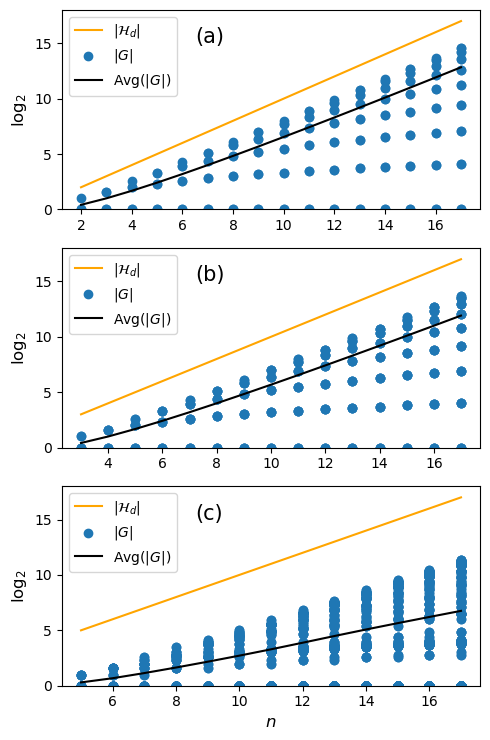

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(5,7.5))
n_max = 17

# heis
n_min = 2
h_x, h_y = hilbert_data(n_min, n_max)
ax[0].plot(h_x, h_y, color='orange', label=r'$|\mathcal{H}_{d}|$')
ax[0].scatter(heis_data_x, heis_data_y, label=r'$|G|$')
ax[0].plot(list(range(n_min,n_max+1)), heis_mean, color='black', label=r'Avg$(|G|)$')
ax[0].set_ylabel(r'$\log_2$', fontsize=12)
ax[0].text((n_max-n_min)*3/10+n_min, 15,'(a)', fontsize=15)
ax[0].legend()


# t6
n_min = 3
h_x, h_y = hilbert_data(n_min, n_max)
ax[1].plot(h_x, h_y, color='orange', label=r'$|\mathcal{H}_{d}|$')
ax[1].scatter(t6_data_x, t6_data_y, label=r'$|G|$')
ax[1].plot(list(range(n_min,n_max+1)), t6_mean, color='black', label=r'Avg$(|G|)$')
ax[1].set_ylabel(r'$\log_2$', fontsize=12)
ax[1].text((n_max-n_min)*3/10+n_min, 15,r'(b)', fontsize=15)
ax[1].legend()


# f4
n_min = 5
h_x, h_y = hilbert_data(n_min, n_max)
ax[2].plot(h_x, h_y, color='orange', label=r'$|\mathcal{H}_{d}|$')
ax[2].scatter(f4_data_x, f4_data_y, label=r'$|G|$')
ax[2].plot(list(range(n_min,n_max+1)), f4_mean, color='black', label=r'Avg$(|G|)$')
ax[2].set_ylabel(r'$\log_2$', fontsize=12)
ax[2].text((n_max-n_min)*3/10+n_min, 15,r'(c)', fontsize=15)
ax[2].legend()


ax[2].set_xlabel(r'$n$', fontsize=12)

plt.setp(ax, ylim=[0,n_max+1])
plt.tight_layout()


plt.savefig('{}/allSubspaceSizes.pdf'.format(FIG_DIR), dpi=500)

## Algorithm V.I Search Failure Rates
For each exemplar, in the range $n\in[k,17]$, check each state in the $Z$-basis to see if it varies at different $\mu$. 

In [4]:
PATH_DIR = 'path-data'
if not os.path.exists(PATH_DIR):
    os.makedirs(PATH_DIR)
    
n_max = 17

### Heisenberg XXX
This is JUST to show that this works, since we have a proof that this method never fails at $\mu=1$.

In [ ]:
n_min = 2
easy_n_max = 12

failure_numbers = []
data_x = []
for n in range(n_min, easy_n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full Heisenberg simulation
    heisenberg_cycle = [] # list( (circuit, q_ids) )
    dt = 4*np.pi/10 # for the current purpose, arbitrary

    # even
    for i in range(0, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(heisenberg_cycle)]
                  )
    
    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    ## Check number of failures
    failure_states = 0
    for space in subspaces:        
        true_min = min(space, key=lambda x: int(x,2))
        for state in space:
            verifier = sps.MeasurementVerifier(computation, state)       
            if int(verifier.greedy_min_sets_search(state),2) != int(true_min,2):
                failure_states += 1
    failure_numbers.append(failure_states/2**n)
    data_x.append(n)

plt.scatter(data_x, failure_numbers)

#### T6 QCA

In [ ]:
n_min = 3
#n_max = 17

t6esc_conds = [1,2]
failure_numbers_ec = []
for i in t6esc_conds:
    failure_numbers_ec.append([])
        
data_x = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full T6QCA simulation
    t6qca_cycle = [] # list( (circuit, q_ids) )

    # even
    for i in range(2, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(t6qca_cycle)]
                  )
      
    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    ## Check rocky subspace count and number of failures
    # check each subspace      
    for i, esc_cond in enumerate(t6esc_conds):
        failure_states = 0
        for space in subspaces:        
            true_min = min(space, key=lambda x: int(x,2))
            # counting states which miss the true minimum
            for state in space:                                
                verifier = sps.MeasurementVerifier(computation, state)            
                if int(verifier.greedy_min_sets_search(state,max_depth=esc_cond),2) != int(true_min,2):
                    failure_states += 1
        
        failure_numbers_ec[i].append(failure_states/2**n)
        
    data_x.append(n)

with open('{}/t6qca_pathfinding.json'.format(PATH_DIR),'w') as f:
    f.write(json.dumps(failure_numbers_ec, indent=2))

In [ ]:
# demo the figure for only this model
t6qca_failure_numbers_ec = json.load(open('{}/t6qca_pathfinding.json'.format(PATH_DIR)))
data_x = list(range(3,n_max+1))

plt.xlabel(r'$n$')
plt.ylabel(r'# paths ending in false minima / $2^n$')
for i,esc_cond in enumerate(t6esc_conds):
    plt.plot(data_x, t6qca_failure_numbers_ec[i], marker='o', label=r'$\mu=$'+str(esc_cond))
plt.legend()

#### F4 QCA

In [ ]:
n_min = 5
#n_max = 17

f4esc_conds = [1,3,5,7,9]
failure_numbers_ec = []
for i in f4esc_conds:
    failure_numbers_ec.append([])
    
data_x = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full F4 QCA simulation
    f4qca_cycle = [] # list( (circuit, q_ids) )

    # list all; this is not the exact implementation in the order of operations, but will result the same in our algos
    for i in range(2, n-2):
        f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))

    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
                  )
    
    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    ## Check rocky subspace count and number of failures
    # check each subspace 
    for i, esc_cond in enumerate(f4esc_conds):
        rocky_subspace_states = 0
        failure_states = 0
        for space in subspaces:        
            true_min = min(space, key=lambda x: int(x,2))
            for state in space:                                
                verifier = sps.MeasurementVerifier(computation, state)            
                if int(verifier.greedy_min_sets_search(state,max_depth=esc_cond),2) != int(true_min,2):
                    failure_states += 1        
        failure_numbers_ec[i].append(failure_states/2**n)
        
    data_x.append(n)

with open('{}/f4qca_pathfinding.json'.format(PATH_DIR),'w') as f:
    f.write(json.dumps(failure_numbers_ec, indent=2))    

In [ ]:
# demo for only the f4
f4qca_failure_numbers_ec = json.load(open('{}/f4qca_pathfinding.json'.format(PATH_DIR)))
data_x = list(range(5,n_max+1))

plt.xlabel(r'$n$')
plt.ylabel(r'# paths ending in false minima / $2^n$')
for i,esc_cond in enumerate(f4esc_conds):
    plt.plot(data_x, f4qca_failure_numbers_ec[i], marker='o', label=r'$\mu=$'+str(esc_cond))
plt.legend()

Combine the t6 and f4 figures for convenience

/var/folders/rv/f6_4p0cj2hd35c2h01w442bd3drs8k/T/ipykernel_2481/3369141375.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


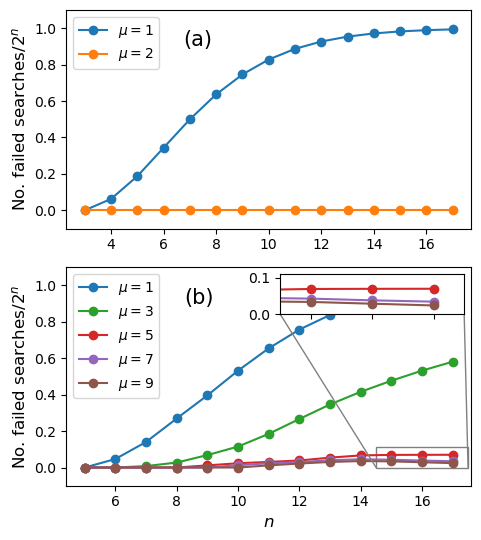

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(5,5.5))

colors = {1: 'C0', 2: 'C1', 3: 'C2', 5: 'C3', 7: 'C4', 9: 'C5'}

# t6qca
t6qca_failure_numbers_ec = json.load(open('{}/t6qca_pathfinding.json'.format(PATH_DIR)))
data_x = list(range(3,n_max+1))
t6esc_conds = [1,2]
for i,esc_cond in enumerate(t6esc_conds):
    ax[0].plot(data_x, t6qca_failure_numbers_ec[i], marker='o', label=r'$\mu=$'+str(esc_cond), color=colors[esc_cond])
# vanity, vanity, all is vanity
ax[0].text((18-3)*2.5/10+3, .9, r'(a)', fontsize=15)    
ax[0].set_ylabel(r'No. failed searches$/2^n$', fontsize=12)


# F4qca
f4qca_failure_numbers_ec = json.load(open('{}/f4qca_pathfinding.json'.format(PATH_DIR)))
data_x = list(range(5,n_max+1))
f4esc_conds = [1,3,5,7,9]
for i,esc_cond in enumerate(f4esc_conds):
    ax[1].plot(data_x, f4qca_failure_numbers_ec[i], marker='o', label=r'$\mu=$'+str(esc_cond), color=colors[esc_cond])
# vanity, vanity, all is vanity
ax[1].text((18-5)*2.5/10+5, .9, r'(b)', fontsize=15)    
ax[1].set_xlabel(r'$n$', fontsize=12)
ax[1].set_ylabel(r'No. failed searches$/2^n$', fontsize=12)

## zoomzoom
x1=14.5
x2=17.5
y1=0
y2=.11
axins = zoomed_inset_axes(ax[1], 2, loc=1) # zoom = 2
for i,esc_cond in enumerate(f4esc_conds):
    axins.plot(data_x, f4qca_failure_numbers_ec[i], marker='o', label=r'$\mu=$'+str(esc_cond), color=colors[esc_cond])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=True)
mark_inset(ax[1], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    
# put up the plot
ax[0].legend()
ax[1].legend()

plt.setp(ax, ylim=[-.1,1.1])
plt.tight_layout()

plt.savefig('{}/allErrorPathsData.pdf'.format(FIG_DIR), dpi=500)

# Algorithm V.I Search Depths
For each exemplar, in the range $n\in[k,17]$, check each state in the $Z$-basis and see the depth (i.e. how many times does $T^\mu$ need to be computed) before the heuristic is satisfied for different relevant $\mu$.

In [ ]:
n_max = 17

#### Heisenberg XXX

In [ ]:
n_min = 2

max_path_lengths = []
heis_data_x = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full Heisenberg simulation
    heisenberg_cycle = [] # list( (circuit, q_ids) )
    dt = 4*np.pi/10 # for the current purpose, arbitrary

    # even
    for i in range(0, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(heisenberg_cycle)]
                  )
    
    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    ## Check all states and get the furthest state from stop minimum
    path_lengths = []
    for space in subspaces:        
        for state in space:
            verifier = sps.MeasurementVerifier(computation, state)    
            verifier.greedy_min_sets_search(state)
            path_lengths.append(verifier.search_depth)            
                
    max_path_lengths.append(max(path_lengths))
    heis_data_x.append(n)

with open('{}/heis_pathlength.json'.format(PATH_DIR),'w') as f:
    f.write(json.dumps(max_path_lengths, indent=2))   

In [ ]:
# demo
max_path_lengths = json.load(open('{}/heis_pathlength.json'.format(PATH_DIR)))
    
plt.scatter(heis_data_x, max_path_lengths, marker='o', label=r'$\max(|Path|)$')
plt.plot(heis_data_x, [x**2/4 for x in heis_data_x], color='orange', label=r'$n^2/4$')

plt.xlabel(r'$n$')
plt.ylabel(r'$|Path|$')
plt.legend()

#### T6 QCA

In [ ]:
n_min = 3

t6esc_conds = [1,2]
max_path_lengths_ec = []
for i in t6esc_conds:
    max_path_lengths_ec.append([])
        
data_x = []
#trend = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full T6QCA simulation
    t6qca_cycle = [] # list( (circuit, q_ids) )

    # even
    for i in range(2, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
    # odd
    for i in range(1, n-1, 2):
        t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
            
    ## Make a simulation
    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(t6qca_cycle)]
                  )
      
    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    #space_sizes = [len(s) for s in subspaces]
    for i, esc_cond in enumerate(t6esc_conds):
        ## Check all states and get the furthest state from stop minimum
        path_lengths = []
        for space in subspaces:        
            for state in space:
                verifier = sps.MeasurementVerifier(computation, state)    
                verifier.greedy_min_sets_search(state, max_depth=esc_cond)
                path_lengths.append(verifier.search_depth)
                
        max_path_lengths_ec[i].append(max(path_lengths))                
        
    data_x.append(n)

with open('{}/t6qca_pathlength.json'.format(PATH_DIR),'w') as f:
    f.write(json.dumps(max_path_lengths_ec, indent=2))      

In [ ]:
# demo
max_path_lengths_ec = json.load(open('{}/t6qca_pathlength.json'.format(PATH_DIR)))
data_x = list(range(3,n_max+1))

# plot
for i,esc_cond in enumerate(t6esc_conds):
    plt.plot(data_x, max_path_lengths_ec[i], marker='o', label=r'$\max|Path|,\,\mu=$'+str(esc_cond))
plt.plot(data_x, [x*np.log(x) for x in data_x], color='black', label=r'$n\log(n)$')

plt.xlabel(r'$n$')
plt.ylabel(r'$|Path|$')
plt.legend()

#### F4 QCA

In [ ]:
n_min = 5
f4esc_conds = [1,3,5,7,9]

max_path_lengths_ec = []
for i in f4esc_conds:
    max_path_lengths_ec.append([])
        
data_x = []
for n in range(n_min, n_max+1):
    ## Qubit information for our simulation
    q = cirq.LineQubit.range(n)
    q_ids = list(range(n))

    ## A full F4 QCA simulation
    f4qca_cycle = [] # list( (circuit, q_ids) )

    # list all; this is not the exact implementation in the order of operations, but will result the same in our algos
    for i in range(2, n-2):
        f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))

    computation = sps.QuantumSystem(
                        [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
                  )    

    ## Get all subspaces, and check the number of corrupted states
    subspaces = computation.hilbert_space_closure(n)
    
    for i, esc_cond in enumerate(f4esc_conds):
        ## Check all states and get the furthest state from stop minimum
        path_lengths = []
        for space in subspaces:        
            for state in space:
                verifier = sps.MeasurementVerifier(computation, state)    
                verifier.greedy_min_sets_search(state, max_depth=esc_cond)
                path_lengths.append(verifier.search_depth)
                
        max_path_lengths_ec[i].append(max(path_lengths))                
        
    data_x.append(n)
    
with open('{}/f4_pathlength.json'.format(PATH_DIR),'w') as f:
    f.write(json.dumps(max_path_lengths_ec, indent=2))   

In [ ]:
# demo 
max_path_lengths_ec = json.load(open('{}/f4_pathlength.json'.format(PATH_DIR)))
data_x = list(range(5,n_max+1))

for i,esc_cond in enumerate(f4esc_conds):
    plt.plot(data_x, max_path_lengths_ec[i], marker='o', label=r'$\max|Path|,\,\mu=$'+str(esc_cond))
plt.plot(data_x, [x*np.log10(x) for x in data_x], color='black', label=r'$n\log_{10}(n)$')

plt.xlabel(r'$n$')
plt.ylabel(r'$|Path|$')
plt.legend()

Combine the plots

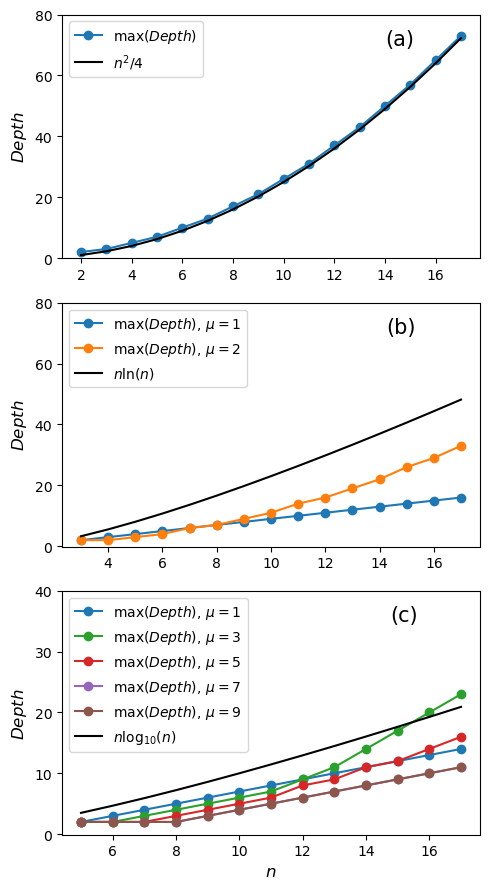

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(5,9))
plt.setp(ax[0], ylim=[-.1,80])
plt.setp(ax[1], ylim=[-.1,80])
plt.setp(ax[2], ylim=[-.1,40]) #f4 has a lower depth

colors = {1: 'C0', 2: 'C1', 3: 'C2', 5: 'C3', 7: 'C4', 9: 'C5'}

# Heis
max_path_lengths = json.load(open('{}/heis_pathlength.json'.format(PATH_DIR)))
data_x = list(range(2,n_max+1))
ax[0].plot(data_x, max_path_lengths, marker='o', label=r'$\max(Depth)$', color=colors[1])
ax[0].plot(data_x, [x**2/4  for x in data_x], color='black', label=r'$n^2/4$')
# vanity
ax[0].set_ylabel(r'$Depth$', fontsize=12)
ax[0].text((18-2)*7.5/10+2, 70, r'(a)', fontsize=15)


# t6qca
max_path_lengths_ec = json.load(open('{}/t6qca_pathlength.json'.format(PATH_DIR)))
data_x = list(range(3,n_max+1))
t6esc_conds = [1,2]
for i,esc_cond in enumerate(t6esc_conds):
    ax[1].plot(data_x, max_path_lengths_ec[i], marker='o', label=r'$\max(Depth),\,\mu=$'+str(esc_cond), color=colors[esc_cond])
ax[1].plot(data_x, [x*np.log(x) for x in data_x], color='black', label=r'$n\ln(n)$')
# vanity
ax[1].set_ylabel(r'$Depth$', fontsize=12)
ax[1].text((18-3)*7.5/10+3, 70, r'(b)', fontsize=15)


# F4qca
max_path_lengths_ec = json.load(open('path-data/f4_pathlength.json'))
data_x = list(range(5,n_max+1))
f4esc_conds = [1,3,5,7,9]
for i,esc_cond in enumerate(f4esc_conds):
    ax[2].plot(data_x, max_path_lengths_ec[i], marker='o', label=r'$\max(Depth),\,\mu=$'+str(esc_cond), color=colors[esc_cond])
ax[2].plot(data_x, [x*np.log10(x) for x in data_x], color='black', label=r'$n\log_{10}(n)$')
# vanity
ax[2].set_ylabel(r'$Depth$', fontsize=12)
ax[2].text((18-5)*7.5/10+5, 7/8*40, r'(c)', fontsize=15)
ax[2].set_xlabel(r'$n$',fontsize=12)


# put up the plot
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')


plt.tight_layout()
plt.savefig('{}/allPathLengthsData.pdf'.format(FIG_DIR), dpi=500)

## Post-Selection
Import all the data and get KL-divergences. We define our own KL divergence, and analyze will get all relevant quantities from the data. There is emulated noisy quantum data, generated by a different notebook (for performance reasons), for each exemplar model. We use the following
+ Heisenberg-XXX, $\mu=1$
+ $T_6$ QCA, $\mu=2$
+ $F_4$ QCA, $\mu=1,2$

With the error rates $\epsilon/3=.005,.01,.02,.05$.

In [4]:
def KL(P,Q):
    epsilon = 2**(-128*4)

    P = np.asarray(P,dtype=float)
    Q = np.asarray(Q,dtype=float)

    divergence = 0
    for i,_ in enumerate(P):        
        if P[i] == 0:
            #P[i] = epsilon
            divergence += 0
            continue
        if Q[i] == 0:
            Q[i] = epsilon            
        divergence += P[i]*np.log(P[i]/Q[i])        
    return divergence

def analyze(computation, model_name, error_probabilities, nmeas, N, esc_conds):
    
    # return all of this
    ideal_data = {err_p: None for err_p in error_probabilities}
    exact_ps_KL = {err_p: None for err_p in error_probabilities}
    err_data = {err_p: None for err_p in error_probabilities}
    err_KL = {err_p: None for err_p in error_probabilities}
    ps_data = {err_p: {esc_cond: None for esc_cond in esc_conds} for err_p in error_probabilities}
    ps_KL = {err_p: {esc_cond: None for esc_cond in esc_conds} for err_p in error_probabilities}
    sps_KL = {err_p: None for err_p in error_probabilities}
    
    
    ## Load and process data
    PS_DIR = 'ps-data'
    for i,err_p in enumerate(error_probabilities):        
        ideal_file = '{}/{}_ideal_N={}_p={}_shots={}.json'.format(PS_DIR,model_name,N,err_p,nmeas)
        noise_file = '{}/{}_noise_N={}_p={}_shots={}.json'.format(PS_DIR,model_name,N,err_p,nmeas)

        ideal_hist = json.load(open(ideal_file))
        noise_hist = json.load(open(noise_file))

        # translate to ideal wvfn squared
        ideal_timeseries = []
        for time_key,hist in ideal_hist:
            wvfn = np.zeros(2**N)
            meas = 0
            for key,value in hist.items():
                wvfn[int(key)] = value
                meas += value
            wvfn /= meas
            ideal_timeseries.append(wvfn)
            
        # translate to noise wvfn squared
        noise_timeseries = []
        for time_key,hist in noise_hist:
            wvfn = np.zeros(2**N)
            meas = 0
            for key,value in hist.items():
                wvfn[int(key)] = value
                meas += value
            wvfn /= meas
            noise_timeseries.append(wvfn)        
                
        # Some constants
        start_bstr = ('{0:0' + str(N) + 'b}').format(int(list(ideal_hist[0][1].keys())[0]))            
        uniform_random_noise = np.zeros(2**N) + 2**-N # incoherent noise
        # Get the distribution from the last time step
        #uniform_random_noise = np.zeros(2**N)
        #print(noise_hist[-1][1])
        #for key,value in noise_hist[-1][1].items():
        #    uniform_random_noise[int(key)] = value/nmeas      
            
            
        ## PS will go as follows
        #### note: this COULD only be done once, but I automate by reading the initial state from each file
        # 1) collect SPS of initial state
        # 2) for each state in SPS, add to 'approved' set for that escape condition
        # 3) post-select by checking for each measurement in the approved set
            
        # PS overhead
        symmetry_protected_subspace = computation.transitive_closure(start_bstr)
        measurement_verifier = sps.MeasurementVerifier(computation, start_bstr)
            
        # Precompute measurements in the SPS
        approved_states = {esc_cond: set([]) for esc_cond in esc_conds}
        # we'll just check all ahead of time
        for state in symmetry_protected_subspace:
            for esc_cond in esc_conds:
                start_min = measurement_verifier.greedy_min_sets_search(start_bstr, esc_cond)
                meas_min = measurement_verifier.greedy_min_sets_search(state, esc_cond)
                if meas_min == start_min:
                    approved_states[esc_cond].add(state)
                        
        # Do the post selection
        postselected_timeseries_ec = {esc_cond: [] for esc_cond in esc_conds}
        for esc_cond in esc_conds:
            for t,hist in noise_hist:
                wvfn = np.zeros(2**N)
                kept_meas = 0                    
                for key,value in hist.items():                        
                    if sps.bstr(int(key), N) in approved_states[esc_cond]:
                        wvfn[int(key)] = value
                        kept_meas += value
                postselected_timeseries_ec[esc_cond].append(wvfn/kept_meas)
                
        # Do double-checked post selection
        exact_postselected_timeseries = []
        for t,hist in noise_hist:
            wvfn = np.zeros(2**N)
            kept_meas = 0
            for key,value in hist.items():
                if sps.bstr(int(key), N) in symmetry_protected_subspace:
                    wvfn[int(key)] = value
                    kept_meas += value
            exact_postselected_timeseries.append(wvfn/kept_meas)

        
        # KL divergence Ideal
        urn_KL = [KL(uniform_random_noise, ideal_timeseries[t]) for t,_ in enumerate(ideal_timeseries)]
        #urn_KL = [KL(ideal_timeseries[t], uniform_random_noise) for t,_ in enumerate(ideal_timeseries)]

        # KL divergence Noise
        noise_KLs = [1-KL(noise_timeseries[t], ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(noise_timeseries)]
        #noise_KLs = [1-KL(ideal_timeseries[t], noise_timeseries[t])/urn_KL[t] for t,_ in enumerate(noise_timeseries)]
        
        # KL divergence exact ps
        exact_ps_KLs = [1-KL(exact_postselected_timeseries[t], ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(exact_postselected_timeseries)]
        #exact_ps_KLs = [1-KL(ideal_timeseries[t], exact_postselected_timeseries[t])/urn_KL[t] for t,_ in enumerate(exact_postselected_timeseries)]

        # KL divergence PS
        ps_KLs = {esc_cond: 
                  [1-KL(postselected_timeseries_ec[esc_cond][t], ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(postselected_timeseries_ec[esc_cond])]
                  #[1-KL(ideal_timeseries[t], postselected_timeseries_ec[esc_cond][t])/urn_KL[t] for t,_ in enumerate(postselected_timeseries_ec[esc_cond])]
                  for esc_cond in esc_conds
                 }
            
        # urn within subspace
        size = len(symmetry_protected_subspace)
        subsys_wvfn = np.zeros(2**N)
        for state in symmetry_protected_subspace:
            subsys_wvfn[int(state,2)] = 1/size
        subspace_KLs = [1-KL(subsys_wvfn, ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(ideal_timeseries)]  
        #subspace_KLs = [1-KL(ideal_timeseries[t], subsys_wvfn)/urn_KL[t] for t,_ in enumerate(ideal_timeseries)]
        
        # data logging
        ideal_data[err_p] = ideal_timeseries
        err_data[err_p] = noise_timeseries
        err_KL[err_p] = noise_KLs
        exact_ps_KL[err_p] = exact_ps_KLs
        for esc_cond in esc_conds:
            ps_data[err_p][esc_cond] = postselected_timeseries_ec[esc_cond]
            ps_KL[err_p][esc_cond] = ps_KLs[esc_cond]
        sps_KL[err_p] = subspace_KLs
    return {
        'ideal_data': ideal_data,
        'err_data': err_data,
        'err_KL': err_KL,
        'ps_data': ps_data,
        'ps_KL': ps_KL,
        'sps_KL': sps_KL,
        'exact_ps_KL': exact_ps_KL
    }

### Heisenberg XXX

In [5]:
n = 15
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

heisenberg_cycle = [] # list( (circuit, q_ids) )
dt = 4*np.pi/10 # for the current purpose, arbitrary
# even
for i in range(0, n-1, 2):
    heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
# odd
for i in range(1, n-1, 2):
    heisenberg_cycle.append((cw.unitary_HeisenbergXXX(q[i], q[i+1], dt),[i,i+1]))
            
## Make a simulation
computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(heisenberg_cycle)]
              )

errs = [.005, .01,.02,.05]
esc_conds = [1]
heisenberg_results = analyze(computation, 'heis', errs, 30_000, n, esc_conds)

In [ ]:
for err in [.005, .01,.02,.05]:
    plt.plot(heisenberg_results['err_KL'][err], '-o')
    for esc_cond in esc_conds:
        plt.plot(heisenberg_results['ps_KL'][err][esc_cond], '-o')
    plt.plot(heisenberg_results['sps_KL'][err])
    plt.show()

As an aside (not used in the paper), we also check the $ZZ$ expectation values, since that would normally be measured for the Heisenberg model

In [ ]:
def zz(b_str):
    z = 0
    for i,val in enumerate(b_str[:-1]):
        if b_str[i] != b_str[i+1]:
            z -= 1
        else:
            z += 1
    return z

def wvfn_zz(dist):
    results = []
    for i,amp in enumerate(dist):
        if amp < 1/30_000: # couldnt have been measured
            continue
        b_str = sps.bstr(i,15)        
        #[results.append(zz(b_str)) for _ in range(int(amp*30_000))]
        results.append(zz(b_str)*amp)
    return np.sum(results), np.std(results)
   


esc_conds = [1]
for err in [.005, .01, .02, .05]:
    plt.cla()
    
    ideal_zz_timeseries = []
    ideal_zz_timeseries_std = []
    for meas_dist in heisenberg_results['ideal_data'][err]:
        a,b = wvfn_zz(meas_dist)        
        ideal_zz_timeseries.append(a)
        ideal_zz_timeseries_std.append(b)            
    plt.plot(ideal_zz_timeseries, '-o', color='C1', label='ideal')
    
    
    err_zz_timeseries = []
    err_zz_timeseries_std = []
    for meas_dist in heisenberg_results['err_data'][err]:
        a,b = wvfn_zz(meas_dist)
        err_zz_timeseries.append(a)
        err_zz_timeseries_std.append(b)
    plt.plot(err_zz_timeseries, '-o', color='C0', label='raw')
        
    ps_zz_timeseries = []
    ps_zz_timeseries_std = []
    for meas_dist in heisenberg_results['ps_data'][err][1]:
        a,b = wvfn_zz(meas_dist)        
        ps_zz_timeseries.append(a)
        ps_zz_timeseries_std.append(b)            
    plt.plot(ps_zz_timeseries, '-o', color='C2', label='ps')
   

    plt.legend()
    plt.show()
    


### T6 QCA

In [6]:
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

## A full T6QCA simulation
t6qca_cycle = [] # list( (circuit, q_ids) )

# even
for i in range(2, n-1, 2):
    t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
# odd
for i in range(1, n-1, 2):
    t6qca_cycle.append((cw.unitary_T6QCA(q[i-1], q[i], q[i+1]),[i-1, i,i+1]))
            
## Make a simulation
computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(t6qca_cycle)]
              )

errs = [.005, .01, .02, .05]
t6qca_esc_conds = [1,2]
t6qca_results = analyze(computation, 't6qca', errs, 30_000, n, t6qca_esc_conds)

In [ ]:
for err in errs:
    plt.plot(t6qca_results['err_KL'][err], '-o')
    for esc_cond in t6qca_esc_conds:
        plt.plot(t6qca_results['ps_KL'][err][esc_cond], '-o')
    plt.plot(t6qca_results['sps_KL'][err])
    plt.show()

Show the time evolution of $\langle n \rangle$, which is normally measured for the QCAs (not examined in our manuscript)

In [ ]:
def n_expectation_val(dist, N):
    ''' take the wvfn squared, get <n> for each qubit '''
    n_dist = np.zeros(N)
    for idx,val in enumerate(dist):
        if val != 0:
            bstr = sps.bstr(idx, N)
            for qubit_idx,state in enumerate(bstr):
                if state == '1':
                    n_dist[qubit_idx] += val
    return n_dist



fig,ax = plt.subplots(4, 3, figsize=(8,20))

for err_idx,err in enumerate([.005, .01, .02, .05]):
    # Ideal
    n_exp_timeseries = []    
    for meas_dist in t6qca_results['ideal_data'][err]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][0].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][0].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    #plt.colorbar()    
    
    # Noisy
    n_exp_timeseries = []    
    for meas_dist in t6qca_results['err_data'][err]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][1].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][1].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    #plt.colorbar()    
    
    # PS
    n_exp_timeseries = []    
    for meas_dist in t6qca_results['ps_data'][err][2]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][2].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][2].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
        
    # plot beautify
    if err_idx != 3: 
        for j in range(3):
            ax[err_idx][j].axes.xaxis.set_ticklabels([])
    ax[err_idx][1].axes.yaxis.set_ticklabels([])
    ax[err_idx][2].axes.yaxis.set_ticklabels([])
    
    
#plt.colorbar()

plt.tight_layout()

### F4 QCA

In [7]:
n = 15
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

## A full F4 QCA simulation
f4qca_cycle = [] # list( (circuit, q_ids) )

# list all; this is not the exact implementation in the order of operations, but will result the same in our algos
for i in range(2, n-2):
    f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))

computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
              )

errs = [.005, .01, .02, .05]
f4qca_esc_conds = [1,2] # NOTE this model only needs this EC
f4qca_results = analyze(computation, 'f4qca', errs, 30_000, n, f4qca_esc_conds)

/var/folders/rv/f6_4p0cj2hd35c2h01w442bd3drs8k/T/ipykernel_76010/876343389.py:101: RuntimeWarning: invalid value encountered in true_divide
  postselected_timeseries_ec[esc_cond].append(wvfn/kept_meas)


In [ ]:
for err in errs:
    plt.plot(f4qca_results['err_KL'][err], '-o')
    for esc_cond in f4qca_esc_conds:
        plt.plot(f4qca_results['ps_KL'][err][esc_cond], '-o', label='{}'.format(esc_cond))
    plt.plot(f4qca_results['sps_KL'][err])
    plt.legend()
    plt.show()

The same population plots as for the $T_6$

In [ ]:
fig,ax = plt.subplots(4, 3, figsize=(8,20))

for err_idx,err in enumerate([.005, .01, .02, .05]):
    # Ideal
    n_exp_timeseries = []    
    for meas_dist in f4qca_results['ideal_data'][err]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][0].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][0].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    #plt.colorbar()    
    
    # Noisy
    n_exp_timeseries = []    
    for meas_dist in f4qca_results['err_data'][err]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][1].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][1].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    #plt.colorbar()    
    
    # PS
    n_exp_timeseries = []    
    for meas_dist in f4qca_results['ps_data'][err][2]:    
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))
    #ax[err_idx][2].rcParams["figure.figsize"] = (10,8)
    ax[err_idx][2].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
        
    # plot beautify
    if err_idx != 3: 
        for j in range(3):
            ax[err_idx][j].axes.xaxis.set_ticklabels([])
    ax[err_idx][1].axes.yaxis.set_ticklabels([])
    ax[err_idx][2].axes.yaxis.set_ticklabels([])
    
    
#plt.colorbar()

plt.tight_layout()

### Dad plot

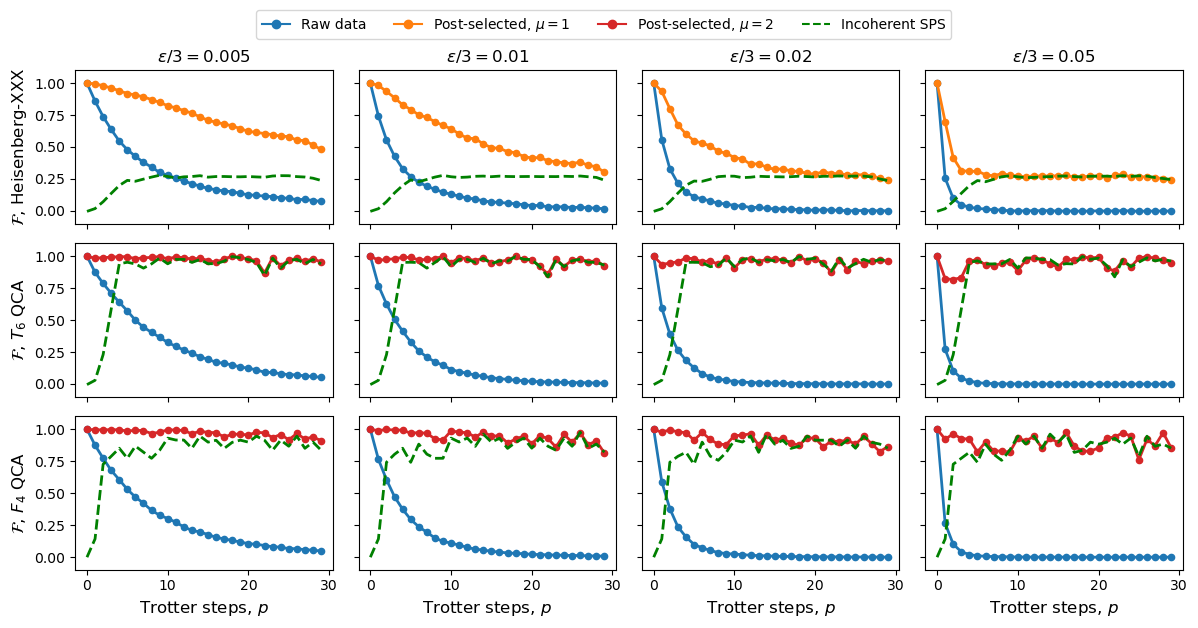

In [13]:
####
# One figure with all the data
####
fig, ax = plt.subplots(3, 4, figsize=(12,6))

errs = [.005, .01, .02, .05]
#cmap = plt.cm.coolwarm
colors = {1: 'C1', 2: 'C3'}
custom_lines = [Line2D([0], [0], marker='o', color='C0'),
                Line2D([0], [0], marker='o', color='C1'),
                Line2D([0], [0], marker='o', color='C3'),
                Line2D([0], [0], linestyle='dashed', color='green'),]

# heisenberg
for i,err in enumerate(errs):
    ax[0][i].plot(heisenberg_results['err_KL'][err], '-o', markersize=4.5, lw=2)  
    ax[0][i].plot(heisenberg_results['ps_KL'][err][1], '-o', markersize=4.5, lw=2)
    ax[0][i].plot(heisenberg_results['sps_KL'][err], color='green', linestyle='dashed', lw=2)  
ax[0][0].set_ylabel(r'$\mathcal{F}$, Heisenberg-XXX', fontsize=12)

# t6qca
for i,err in enumerate(errs):
    ax[1][i].plot(t6qca_results['err_KL'][err], '-o', markersize=4.5, lw=2)
    for esc_cond in [2]:
        ax[1][i].plot(t6qca_results['ps_KL'][err][esc_cond], '-o', color=colors[esc_cond], markersize=4.5, lw=2)
    ax[1][i].plot(t6qca_results['sps_KL'][err], color='green', linestyle='dashed', lw=2)
ax[1][0].set_ylabel(r'$\mathcal{F}$, $T_6$ QCA', fontsize=12)
    
# f4qca
for i,err in enumerate(errs):
    ax[2][i].plot(f4qca_results['err_KL'][err], '-o', markersize=4.5, lw=2)
    for esc_cond in [2]:
        ax[2][i].plot(f4qca_results['ps_KL'][err][esc_cond], '-o', color=colors[esc_cond], markersize=4.5, lw=2)
    ax[2][i].plot(f4qca_results['sps_KL'][err], color='green', linestyle='dashed', lw=2)
    ax[2][i].set_xlabel(r'Trotter steps, $p$', fontsize=12)
ax[2][0].set_ylabel(r'$\mathcal{F}$, $F_4$ QCA', fontsize=12)
    
# clean up axes
for i in range(3):
    for j in range(4):
        if i != 2:
            ax[i][j].axes.xaxis.set_ticklabels([])
        if j != 0:
            ax[i][j].axes.yaxis.set_ticklabels([])

ax[0][0].set_title(r'$\epsilon/3=0.005$', fontsize=12)
ax[0][1].set_title(r'$\epsilon/3=0.01$', fontsize=12)
ax[0][2].set_title(r'$\epsilon/3=0.02$', fontsize=12)
ax[0][3].set_title(r'$\epsilon/3=0.05$', fontsize=12)
            
    
# put up the plot
#handles, labels = ax[2][0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor = [.5, 1.05])
fig.legend(custom_lines, ["Raw data", r"Post-selected, $\mu=1$", r"Post-selected, $\mu=2$", "Incoherent SPS"], loc='upper center', ncol=4, bbox_to_anchor = [.5, 1.05])

#h2, l2 = ax[1][1].get_legend_handles_labels()
#fig.legend(handles+h2, labels+l2, loc='upper center', ncol=4)

plt.setp(ax, ylim=[-.1,1.1])
plt.tight_layout()


plt.savefig('{}/allPSDatashots30000.pdf'.format(FIG_DIR), dpi=600, bbox_inches='tight')

## $F_4$ with imperfect pathfinding
Find all states $S$ such that $\chi(S, \mu=9) \neq G_{\min}$ with $\mu=9$, and run a simulation with $U_{F_4}(t=30)|S\rangle$. This will take the steps
+ Find subspaces with paths which fail (18 such subspaces)
+ Choose random state to initizlize in each subspace, simulate $F_4$ for each of these
+ Post-select as best as we can


In [ ]:
## Find F4 subspace resistant to high mu
n = 15
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

## A full F4 QCA simulation
f4qca_cycle = [] # list( (circuit, q_ids) )

# list all; this is not the exact implementation in the order of operations, but will result the same in our algos
for i in range(2, n-2):
    f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))

computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
              )

subspaces = computation.hilbert_space_closure(n)
esc_cond = 9
rocky_subspace_states = 0
failed_spaces = []
failed_states = []
for space in subspaces:        
    true_min = min(space, key=lambda x: int(x,2))
    for state in space:                                
        verifier = sps.MeasurementVerifier(computation, state)    
        if int(verifier.greedy_min_sets_search(state,max_depth=esc_cond),2) != int(true_min,2):
            #failure_states += 1        
            failed_spaces.append(list(space))
            failed_states.append(state)
            break

failed_spaces_initconds = []
print('spaces:', len(subspaces))
print('spaces with failures at mu=9:', len(failed_spaces))
for f in failed_spaces:
    failed_spaces_initconds.append(f[0])
print(failed_spaces)
print()
print(failed_states)

We are going to use the following states:
  '001000011111111', '011100000001000', '011110101011111', '011110000010001', '011101000001000', 
  '011000000101010', '011110111110011', '010110111110100', '100010000010000', '101000111011111', 
  '101111010100001', '101000010001000', '111111101111100', '110111111110101', '111111101010111', 
  '111100010111110', '110111111010001', '110101000000100' 

### Imperfect searching, $\epsilon/3=0.02$
**NOTE** the imperfect searching on non-ideal data assumes multiple measurement numbers, which we do not use in the manuscript. We only use 5,000 shots for this dataset. However, this reasearch code was written for 1000,2000,5000. In the interest of not breaking anything, we leave the analysis here.

In [9]:
n = 15
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

# Setup a computation for post selection algorithm
## A full F4 QCA simulation
f4qca_cycle = []
for i in range(2, n-2):
    f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))
computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
              )

#nmeas = 5_000
nmeas_list = [10_000]
#nmeas_list = [5_000]
errs = [.02]                                                
imperfect_esc_conds = [1,3,5,7,9]#,12]                            
init_conds = ['001000011111111', '011100000001000', '011110101011111', '011110000010001', '011101000001000', '011000000101010',
              '011110111110011', '010110111110100', 
              '100010000010000', '101000111011111', '101111010100001', '101000010001000',
              '111111101111100', '110111111110101', '111111101010111', '111100010111110', '110111111010001', '110101000000100']                                                    
results_dict = {}

for nmeas in nmeas_list:
    results_dict[nmeas] = {}
    for init_cond in init_conds: 
        results_dict[nmeas][init_cond] = analyze(computation, 'imperfect/f4qca{}'.format(init_cond), errs, nmeas, n, imperfect_esc_conds)        

/var/folders/rv/f6_4p0cj2hd35c2h01w442bd3drs8k/T/ipykernel_76010/876343389.py:101: RuntimeWarning: invalid value encountered in true_divide
  postselected_timeseries_ec[esc_cond].append(wvfn/kept_meas)


This cell shows how increasing the number of measurements at smaller shot numbers does increase the accuracy, even though this data is not used in the manuscript

In [ ]:
# demo
#####
# all data
#####
fig, ax = plt.subplots(3, 4, figsize=(12,6))

err = .02

for meas_idx,nmeas in enumerate(nmeas_list):
    avg_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
    std_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
    max_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
    min_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
    for idx,esc_cond in enumerate([3,5,7,9]):#imperfect_esc_conds):
        for t in range(30):
            l = np.nan_to_num([results_dict[nmeas][i]['ps_KL'][err][esc_cond][t] for i in init_conds])        
            avg_kls[esc_cond][t] = np.mean(l)
            std_kls[esc_cond][t] = np.std(l)
            max_kls[esc_cond][t] = max(l)
            min_kls[esc_cond][t] = min(l)
        ax[meas_idx][idx].errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond], label=r'mean$(\{\mathcal{F}\})$')
        ax[meas_idx][idx].plot(max_kls[esc_cond], label=r'$\max(\{\mathcal{F}\})$')
        ax[meas_idx][idx].plot(min_kls[esc_cond], label=r'$\min(\{\mathcal{F}\})$')
    
        # beautify
        ax[0][idx].set_title(r'$\mu={}$'.format(esc_cond), fontsize=12)
        ax[2][idx].set_xlabel(r'Trotter steps, $t$', fontsize=12)

for i in range(3):
    for j in range(4):
        if j != 0:
            ax[i][j].axes.yaxis.set_ticklabels([])
        if i != 2:
            ax[i][j].axes.xaxis.set_ticklabels([])
    ax[i][0].set_ylabel(r'$\mathcal{F}$',fontsize=12)

handles, labels = ax[2][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor = [.5, 1.05], fontsize=12)

plt.setp(ax, ylim=[-1.1,1.1])
plt.tight_layout()


#plt.savefig('allPSBADData_shots=5000.png', dpi=600, bbox_inches='tight')

### Imperfect searching, $\epsilon/3=0.00$

In [10]:
def analyze_perf_wvfn(computation, model_name, error_probabilities, nmeas, N, esc_conds):
    # return all of this
    ideal_data = {err_p: None for err_p in error_probabilities}
    err_data = {err_p: None for err_p in error_probabilities}
    err_KL = {err_p: None for err_p in error_probabilities}
    ps_data = {err_p: {esc_cond: None for esc_cond in esc_conds} for err_p in error_probabilities}
    ps_KL = {err_p: {esc_cond: None for esc_cond in esc_conds} for err_p in error_probabilities}
    sps_KL = {err_p: None for err_p in error_probabilities}
    
    
    ## Load and process data
    PS_DIR = 'ps-data'
    for i,err_p in enumerate(error_probabilities):        
        ideal_file = '{}/{}_ideal_N={}_p={}_shots={}.json'.format(PS_DIR,model_name,N,err_p,nmeas)
        noise_file = '{}/{}_ideal_N={}_p={}_shots={}.json'.format(PS_DIR,model_name,N,err_p,nmeas) # just changed this to examine ideal data

        ideal_hist = json.load(open(ideal_file))
        noise_hist = json.load(open(noise_file))

        # translate to ideal wvfn squared
        ideal_timeseries = []
        for time_key,hist in ideal_hist:
            wvfn = np.zeros(2**N)
            meas = 0
            for key,value in hist.items():
                wvfn[int(key)] = value
                meas += value
            wvfn /= meas
            ideal_timeseries.append(wvfn)
            
        # translate to noise wvfn squared
        noise_timeseries = []
        for time_key,hist in noise_hist:
            wvfn = np.zeros(2**N)
            meas = 0
            for key,value in hist.items():
                wvfn[int(key)] = value
                meas += value
            wvfn /= meas
            noise_timeseries.append(wvfn)        
                
        # Some constants
        start_bstr = ('{0:0' + str(N) + 'b}').format(int(list(ideal_hist[0][1].keys())[0]))            
        uniform_random_noise = np.zeros(2**N) + 2**-N # incoherent noise
            
            
        ## PS will go as follows
        #### note: this COULD only be done once, but I automate by reading the initial state from each file
        # 1) collect SPS of initial state
        # 2) for each state in SPS, add to 'approved' set for that escape condition
        # 3) post-select by checking for each measurement in the approved set
            
        # PS overhead
        symmetry_protected_subspace = computation.transitive_closure(start_bstr)
        measurement_verifier = sps.MeasurementVerifier(computation, start_bstr)
            
        # Precompute measurements in the SPS
        approved_states = {esc_cond: set([]) for esc_cond in esc_conds}
        # we'll just check all ahead of time
        for state in symmetry_protected_subspace:
            for esc_cond in esc_conds:
                start_min = measurement_verifier.greedy_min_sets_search(start_bstr, esc_cond)
                meas_min = measurement_verifier.greedy_min_sets_search(state, esc_cond)
                if meas_min == start_min:
                    approved_states[esc_cond].add(state)
                        
        # Do the post selection
        postselected_timeseries_ec = {esc_cond: [] for esc_cond in esc_conds}
        for esc_cond in esc_conds:
            for t,hist in noise_hist:
                wvfn = np.zeros(2**N)
                kept_meas = 0                    
                for key,value in hist.items():                        
                    if sps.bstr(int(key), N) in approved_states[esc_cond]:
                        wvfn[int(key)] = value
                        kept_meas += value
                postselected_timeseries_ec[esc_cond].append(wvfn/kept_meas)

                    
        # KL divergence Ideal
        urn_KL = [KL(uniform_random_noise, ideal_timeseries[t]) for t,_ in enumerate(ideal_timeseries)]

        # KL divergence Noise
        noise_KLs = [1-KL(noise_timeseries[t], ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(noise_timeseries)]

        # KL divergence PS
        ps_KLs = {esc_cond: 
                  [1-KL(postselected_timeseries_ec[esc_cond][t], ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(postselected_timeseries_ec[esc_cond])]
                  for esc_cond in esc_conds
                 }
            
        # urn within subspace
        size = len(symmetry_protected_subspace)
        subsys_wvfn = np.zeros(2**N)
        for state in symmetry_protected_subspace:
            subsys_wvfn[int(state,2)] = 1/size
        subspace_KLs = [1-KL(subsys_wvfn, ideal_timeseries[t])/urn_KL[t] for t,_ in enumerate(ideal_timeseries)]                    
        
        # data logging
        ideal_data[err_p] = ideal_timeseries
        err_data[err_p] = noise_timeseries
        err_KL[err_p] = noise_KLs
        for esc_cond in esc_conds:
            ps_data[err_p][esc_cond] = postselected_timeseries_ec[esc_cond]
            ps_KL[err_p][esc_cond] = ps_KLs[esc_cond]
        sps_KL[err_p] = subspace_KLs
    return {
        'ideal_data': ideal_data,
        'err_data': err_data,
        'err_KL': err_KL,
        'ps_data': ps_data,
        'ps_KL': ps_KL,
        'sps_KL': sps_KL
    }

In [11]:
n = 15
q = cirq.LineQubit.range(n)
q_ids = list(range(n))

# Setup a computation for post selection algorithm
## A full F4 QCA simulation
f4qca_cycle = []
for i in range(2, n-2):
    f4qca_cycle.append((cw.unitary_F4QCA(q[i], [q[i-2], q[i-1], q[i+1], q[i+2]]), [i-2,i-1,i,i+1,i+2]))
computation = sps.QuantumSystem(
                    [sps.StringEditMap(cirq.unitary(op[0]), op[1]) for _, op in enumerate(f4qca_cycle)]
              )

nmeas = 10_000
errs = [.02]                                                
imperfect_esc_conds = [1,3,5,7,9]#,12]                            
init_conds = ['001000011111111', '011100000001000', '011110101011111', '011110000010001', '011101000001000', '011000000101010',                                                     
              '011110111110011', '010110111110100', 
              '100010000010000', '101000111011111', '101111010100001', '101000010001000',
              '111111101111100', '110111111110101', '111111101010111', '111100010111110', '110111111010001', '110101000000100']                                                    
perf_results_dict = {}                                           
for init_cond in init_conds:                                
    perf_results_dict[init_cond] = analyze_perf_wvfn(computation, 'imperfect/f4qca{}'.format(init_cond), errs, nmeas, n, imperfect_esc_conds)

In [ ]:
#for err in errs:
err = .02
for i in init_conds:
    plt.plot(perf_results_dict[i]['err_KL'][err], '-o')
    for esc_cond in imperfect_esc_conds:
        plt.plot(perf_results_dict[i]['ps_KL'][err][esc_cond], '-o', label='{}'.format(esc_cond))
    plt.plot(perf_results_dict[i]['sps_KL'][err])
    plt.legend()
    #plt.show()
    plt.cla()

avg_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
std_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
max_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
min_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
for esc_cond in imperfect_esc_conds:
    for t in range(30):
        l = np.nan_to_num([perf_results_dict[i]['ps_KL'][err][esc_cond][t] for i in init_conds])        
        avg_kls[esc_cond][t] = np.mean(l)
        std_kls[esc_cond][t] = np.std(l)
        max_kls[esc_cond][t] = max(l)
        min_kls[esc_cond][t] = min(l)
    plt.errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond])
    plt.plot(max_kls[esc_cond])
    plt.plot(min_kls[esc_cond])
    plt.show()

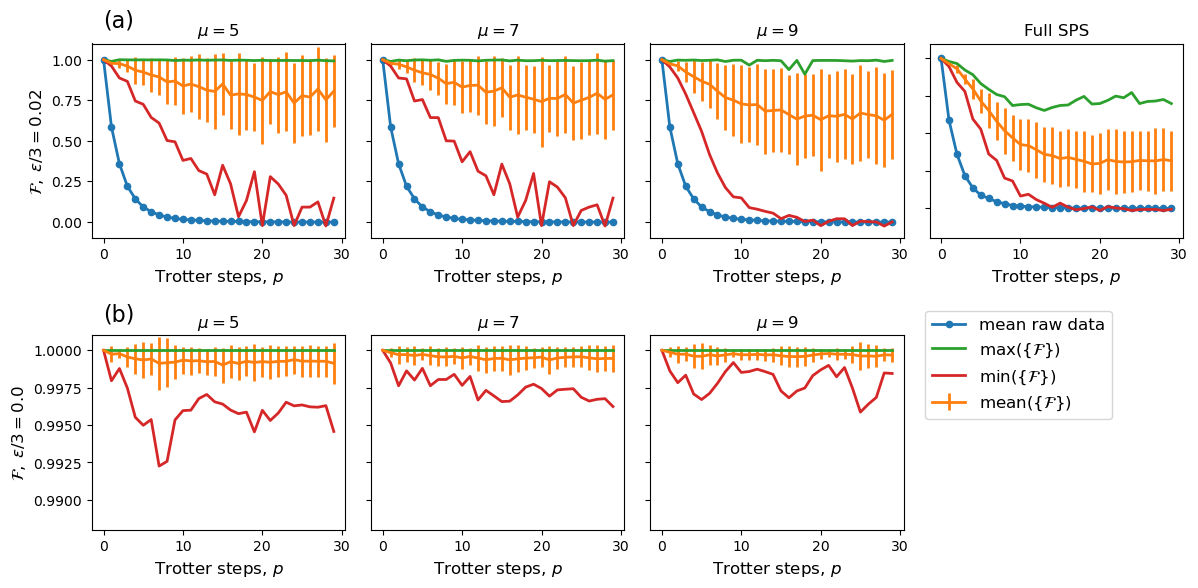

In [21]:
#####
# all data
#####
fig, ax = plt.subplots(2, 4, figsize=(12,6))

###
# Plot a
###
err = .02
# with eror
nmeas = 10_000
avg_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
std_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
max_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
min_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
for idx,esc_cond in enumerate([5,7,9]):
    ax[0][idx].plot([np.mean([results_dict[nmeas][i]['err_KL'][err][t] for i in init_conds]) for t in range(30)], '-o', label='mean raw data', markersize=4.5, lw=2)
    for t in range(30):    
        l = np.nan_to_num([results_dict[nmeas][i]['ps_KL'][err][esc_cond][t] for i in init_conds])        
        ssl = np.nan_to_num([(results_dict[nmeas][i]['ps_KL'][err][esc_cond][t],i) for i in init_conds])
        #print(min(ssl, key=lambda a:a[0]))
        avg_kls[esc_cond][t] = np.mean(l)
        std_kls[esc_cond][t] = np.std(l)
        max_kls[esc_cond][t] = max(l)
        min_kls[esc_cond][t] = min(l)
    ax[0][idx].errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond], label=r'mean$(\{\mathcal{F}\})$', lw=2)
    ax[0][idx].plot(max_kls[esc_cond], label=r'$\max(\{\mathcal{F}\})$', lw=2)
    ax[0][idx].plot(min_kls[esc_cond], label=r'$\min(\{\mathcal{F}\})$', lw=2)
    
    # vanity, vanity, all is vanity
    ax[0][idx].set_title(r'$\mu={}$'.format(esc_cond), fontsize=12)
    ax[0][idx].set_xlabel(r'Trotter steps, $p$', fontsize=12)    
    ax[0][idx].set_ylim([-.1, 1.1])

# plot perfect subspace PS
idx = 3
ax[0][idx].plot(results_dict[nmeas][init_conds[0]]['err_KL'][err], '-o', label='mean raw data', lw=2, markersize=4.5)
for t in range(30):    
    l = np.nan_to_num([results_dict[nmeas][i]['exact_ps_KL'][err][t] for i in init_conds])        
    avg_kls[esc_cond][t] = np.mean(l)
    std_kls[esc_cond][t] = np.std(l)
    max_kls[esc_cond][t] = max(l)
    min_kls[esc_cond][t] = min(l)
ax[0][idx].errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond], label=r'mean$(\{\mathcal{F}\})$', lw=2)
ax[0][idx].plot(max_kls[esc_cond], label=r'$\max(\{\mathcal{F}\})$', lw=2)
ax[0][idx].plot(min_kls[esc_cond], label=r'$\min(\{\mathcal{F}\})$', lw=2)
    
# beautify
ax[0][idx].set_title(r'Full SPS', fontsize=12)
ax[0][idx].set_xlabel(r'Trotter steps, $p$', fontsize=12)
    
ax[0][idx].set_ylim([-.2, 1.1])
ax[0][0].set_ylabel(r'$\mathcal{F},\:\epsilon/3=0.02$', fontsize=12)
ax[0][1].axes.yaxis.set_ticklabels([])
ax[0][2].axes.yaxis.set_ticklabels([])
ax[0][3].axes.yaxis.set_ticklabels([])



###
# Plot b
###
avg_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
std_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
max_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
min_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
for idx,esc_cond in enumerate([5,7,9]):
    for t in range(30):        
        l = np.nan_to_num([perf_results_dict[i]['ps_KL'][err][esc_cond][t] for i in init_conds])        
        avg_kls[esc_cond][t] = np.mean(l)
        std_kls[esc_cond][t] = np.std(l)
        max_kls[esc_cond][t] = max(l)
        min_kls[esc_cond][t] = min(l)
    ax[1][idx].errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond], label=r'mean$(\{\mathcal{F}\})$', color='C1', lw=2)
    ax[1][idx].plot(max_kls[esc_cond], label=r'$\max(\{\mathcal{F}\})$', color='C2', lw=2)
    ax[1][idx].plot(min_kls[esc_cond], label=r'$\min(\{\mathcal{F}\})$', color='C3', lw=2)
    
    # vanity, vanity, all is vanity
    ax[1][idx].set_title(r'$\mu={}$'.format(esc_cond), fontsize=12)
    ax[1][idx].set_xlabel(r'Trotter steps, $p$', fontsize=12)    
    ax[1][idx].set_ylim([.988, 1.001])

# beautify
ax[1][0].set_ylabel(r'$\mathcal{F},\:\epsilon/3=0.0$', fontsize=12)
ax[1][1].axes.yaxis.set_ticklabels([])
ax[1][2].axes.yaxis.set_ticklabels([])
ax[1][3].set_visible(False)



ax[0][0].text(0, 1.2, r'(a)', fontsize=16, clip_box = False)
ax[1][0].text(0, 1.002, r'(b)', fontsize=16, clip_box = False)


handles, labels = ax[0][2].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', bbox_to_anchor = [.93, .38], fontsize=12)

plt.tight_layout()

plt.savefig('{}/allPSBADDatashots10000.pdf'.format(FIG_DIR), dpi=600, bbox_inches='tight')

Population plots for ALL imperfect PS data

In [ ]:
#####
# all data
#####
fig, ax = plt.subplots(18, 5, figsize=(10,40))

err = .02

# with eror
nmeas = 5_000
#avg_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
#std_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
#max_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
#min_kls = {esc_cond: np.zeros(30) for esc_cond in imperfect_esc_conds}
#print(results_dict[5000][init_conds[0]])
for init_idx,i in enumerate(init_conds):
    # ideal
    n_exp_timeseries = []    
    for meas_dist in results_dict[nmeas][i]['ideal_data'][err]:#[]['ps_data'][err][9]:                
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))        
    ax[init_idx][0].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    
    
    # noisy
    n_exp_timeseries = []    
    for meas_dist in results_dict[nmeas][i]['err_data'][err]:#[]['ps_data'][err][9]:                
        n_exp_timeseries.append(n_expectation_val(meas_dist, 15))        
    ax[init_idx][1].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
    
    for idx,esc_cond in enumerate([5,7,9]):#imperfect_esc_conds):                
        # PS
        n_exp_timeseries = []    
        for meas_dist in results_dict[nmeas][i]['ps_data'][err][esc_cond]:#[]['ps_data'][err][9]:                
            n_exp_timeseries.append(n_expectation_val(meas_dist, 15))        
        ax[init_idx][2+idx].imshow(n_exp_timeseries, vmin=0, vmax=1, cmap='seismic')
        
        
    
        #ax[0][idx].plot(results_dict[nmeas][i]['err_KL'][err], '-o', label='Raw data')
        #for t in range(30):
        #    l = np.nan_to_num([results_dict[nmeas][i]['ps_KL'][err][esc_cond][t] for i in init_conds])        
        #    avg_kls[esc_cond][t] = np.mean(l)
        #    std_kls[esc_cond][t] = np.std(l)
        #    max_kls[esc_cond][t] = max(l)
        #    min_kls[esc_cond][t] = min(l)
        #ax[0][idx].errorbar(list(range(30)), avg_kls[esc_cond], std_kls[esc_cond], label=r'mean$(\{\mathcal{F}\})$')
        #ax[0][idx].plot(max_kls[esc_cond], label=r'$\max(\{\mathcal{F}\})$')
        #ax[0][idx].plot(min_kls[esc_cond], label=r'$\min(\{\mathcal{F}\})$')
    
        # beautify
        #ax[0][idx].set_title(r'$\mu={}$'.format(esc_cond), fontsize=12)
        #ax[0][idx].set_xlabel(r'Trotter steps, $t$', fontsize=12)
    
        #ax[0][idx].set_ylim([-.5, 1.1])

#ax[0][1].axes.yaxis.set_ticklabels([])
#ax[0][2].axes.yaxis.set_ticklabels([])


In [ ]:
plt.plot([np.mean([results_dict[nmeas][i]['err_KL'][err][t] for i in init_conds]) for t in range(30)], '-o', label='Raw data')